# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import gc

# Prepare Data

In [2]:
dir_path = '/content'

In [3]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [4]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
itr = test_datagen.flow_from_directory(
  dir_path + '/seg_test/seg_test/',
  target_size=(150, 150),
  batch_size=20000)

X_test, y_test = itr.next()
print(X_test.shape)
print(y_test.shape)

Found 3000 images belonging to 6 classes.
(3000, 150, 150, 3)
(3000, 6)


In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
itr = train_datagen.flow_from_directory(
  dir_path + '/seg_train/seg_train/',
  target_size=(150, 150),
  batch_size=20000)

X_train, y_train = itr.next()
print(X_train.shape)
print(y_train.shape)

Found 14034 images belonging to 6 classes.
(14034, 150, 150, 3)
(14034, 6)


In [6]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print(X.shape)
print(y.shape)

(17034, 150, 150, 3)
(17034, 6)


In [7]:
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [8]:
X_train = X[:int(len(X)*.9)]
y_train = y[:int(len(X)*.9)]
X_test = X[int(len(X)*.9):]
y_test = y[int(len(X)*.9):]

In [9]:
del X
del y
gc.collect()

113

# Explore Data

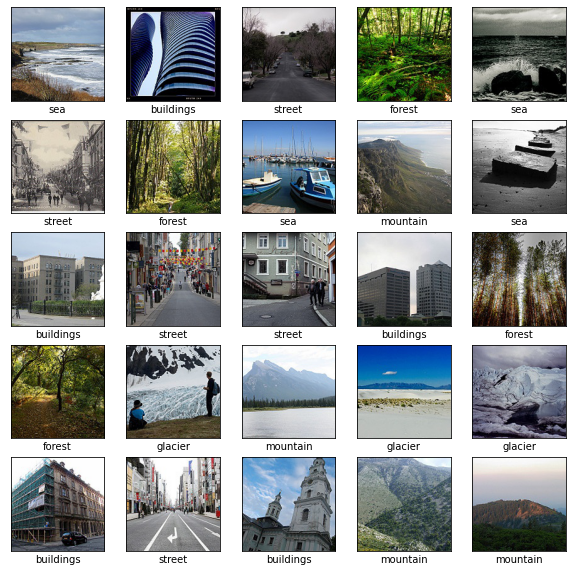

In [10]:
labels = np.argmax(y_train[:25], axis=1) 
fig = plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[labels[i]])
plt.show()

# Define Model

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 64)      

# Train

In [17]:
gc.collect()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
	
# checkpoint_filepath = 'weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_filepath = 'best-weights.h5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    batch_size = 64,
    epochs = 100,
    callbacks=[early_stopping, model_checkpoint]
)

gc.collect()

Epoch 1/100
216/216 [==============================] - 8s 35ms/step - loss: 1.3611 - accuracy: 0.4411 - val_loss: 1.1809 - val_accuracy: 0.5251
Epoch 2/100
216/216 [==============================] - 7s 32ms/step - loss: 1.0933 - accuracy: 0.5670 - val_loss: 1.0963 - val_accuracy: 0.5656
Epoch 3/100
216/216 [==============================] - 7s 32ms/step - loss: 1.0088 - accuracy: 0.6048 - val_loss: 1.0003 - val_accuracy: 0.6282
Epoch 4/100
216/216 [==============================] - 7s 32ms/step - loss: 0.9367 - accuracy: 0.6420 - val_loss: 0.9253 - val_accuracy: 0.6386
Epoch 5/100
216/216 [==============================] - 7s 32ms/step - loss: 0.8642 - accuracy: 0.6699 - val_loss: 0.8525 - val_accuracy: 0.6758
Epoch 6/100
216/216 [==============================] - 7s 32ms/step - loss: 0.8301 - accuracy: 0.6885 - val_loss: 0.8223 - val_accuracy: 0.6947
Epoch 7/100
216/216 [==============================] - 7s 31ms/step - loss: 0.7713 - accuracy: 0.7087 - val_loss: 0.7883 - val_accuracy:

1434

## Accuracy and Loss plots

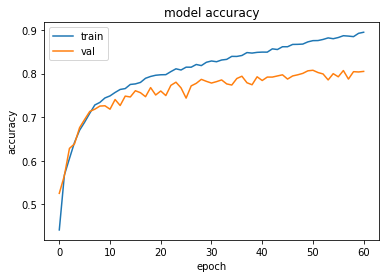

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

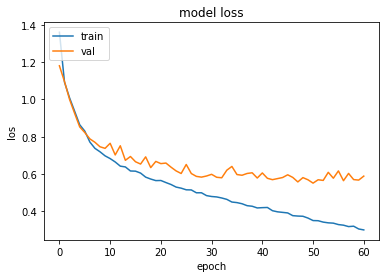

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('los')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict

In [20]:
# model = tf.keras.models.load_model('best-weights.h5')
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test,axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       277
           1       0.91      0.96      0.93       284
           2       0.77      0.75      0.76       295
           3       0.81      0.76      0.78       317
           4       0.77      0.85      0.81       261
           5       0.83      0.75      0.79       270

    accuracy                           0.81      1704
   macro avg       0.81      0.81      0.81      1704
weighted avg       0.81      0.81      0.81      1704



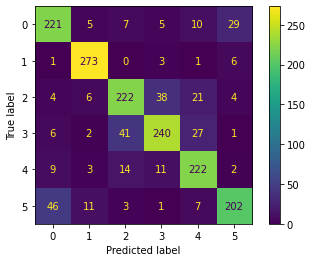

In [21]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

# Error Analysis

In [24]:
def display_examples(class_names, images, labels):    
  fig = plt.figure(figsize=(15,15))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
  plt.show()

def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
  BOO = (y_true == y_pred)
  mislabeled_indices = np.where(BOO == 0)
  mislabeled_images = X_test[mislabeled_indices]
  mislabeled_labels = y_pred[mislabeled_indices]

  title = "Some examples of mislabeled images by the classifier:"
  display_examples(class_names, mislabeled_images, mislabeled_labels)

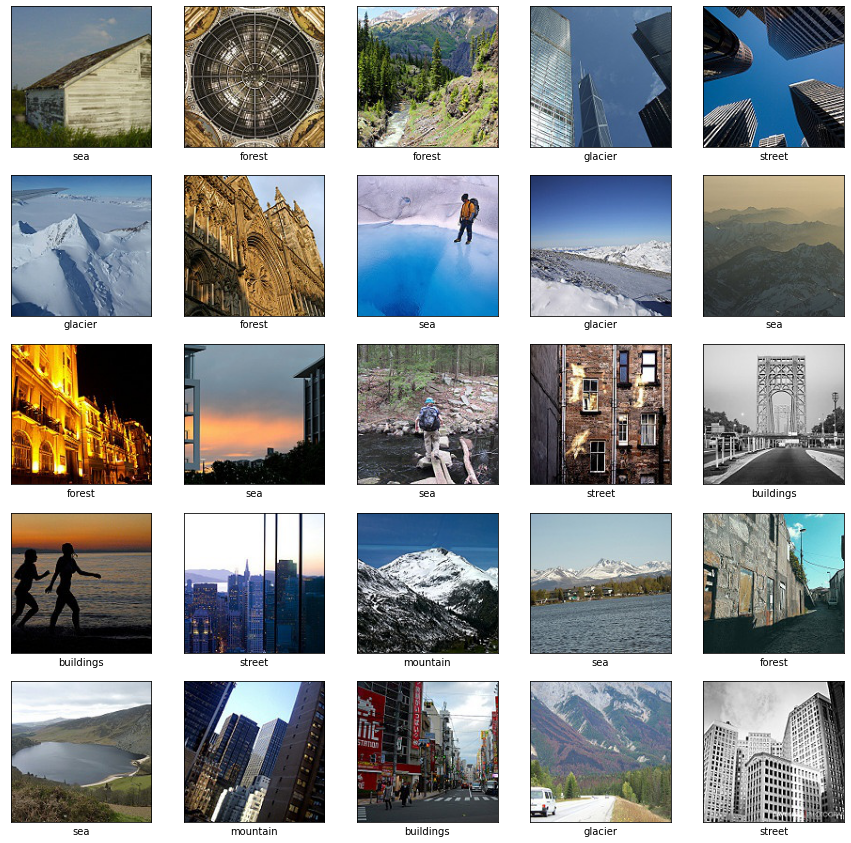

In [25]:
print_mislabeled_images(class_names, X_test, y_true, y_pred)